# DiCE Demo on the Adult Income Dataset

In [4]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from recourse_methods import dice_method
from models import regression
from core import recourse_iterator
from data import data_adapter as da
from models import model_utils
from core import utils
from visualize.two_d_plots import Display2DPaths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data and model

	 c: 0.0001, accuracy: 0.9897951850521021
	 c: 0.001, accuracy: 0.8741645706072584
	 c: 0.01, accuracy: 0.8117858426158822
	 c: 10.0, accuracy: 0.7962630255120373
	 c: 1.0, accuracy: 0.7964786201940353
	 c: 10.0, accuracy: 0.7962630255120373
	 c: 100.0, accuracy: 0.7962630255120373
0.9897951850521021


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


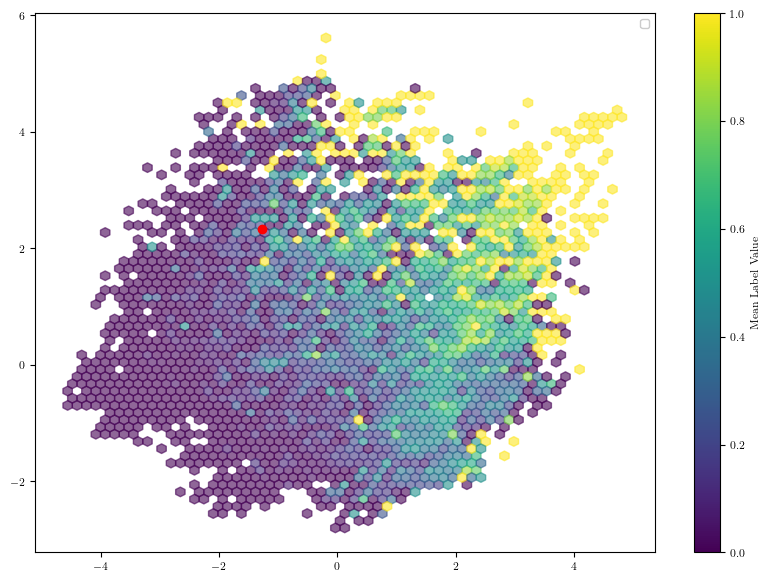

In [53]:
dataset, testset, preprocessor = da.load_adult_income_dataset()
poi = utils.random_poi(dataset, column='income', label = '<=50K')

model, score = regression.train_model(dataset, testset, preprocessor)
print(score)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
).set_poi(preprocessor.transform_series(poi)).do_pca().heatmap()

## Generate some recourse directions

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


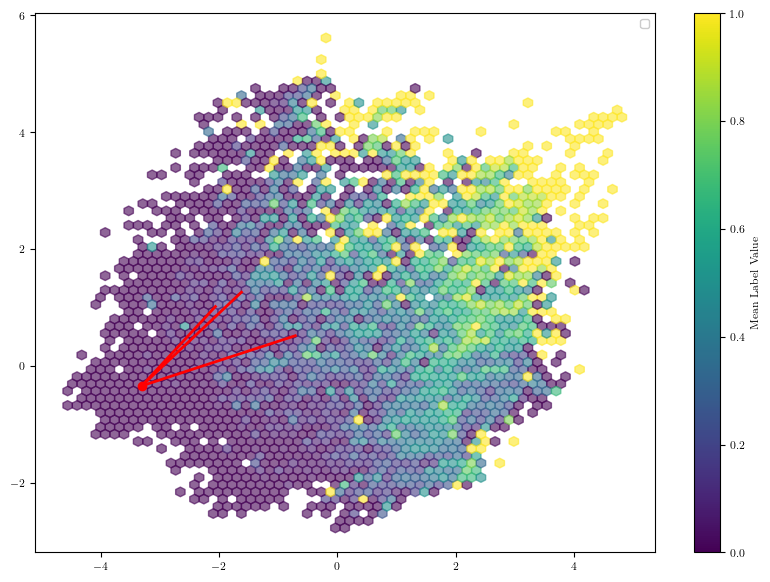

In [49]:
k_directions = 3

dice = dice_method.DiCE(
    k_directions,
    preprocessor,
    dataset,
    preprocessor.continuous_features,
    model,
    model_backend='sklearn',
    label_column='income')

poix = preprocessor.transform_series(poi)
dirs = dice.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
).do_pca().set_poi(poix).set_dirs(dirs, poix).heatmap()

## Generate some paths

Because DiCE generates counterfactual examples, the first direction it gives typically terminates in a valid CFE.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


[[0.24399589 0.75600411]]
[[0.19477659 0.80522341]]
[[0.24316838 0.75683162]]


(<Figure size 1000x700 with 2 Axes>, <AxesSubplot:>)

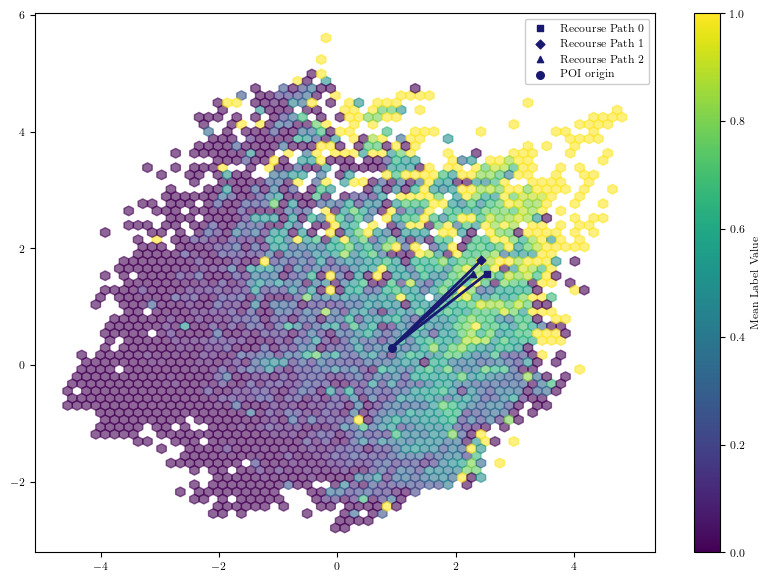

In [66]:
check_certainty = recourse_iterator.wrap_model(model)
certainty_cutoff = 0.75


dice = dice_method.DiCE(
    k_directions,
    preprocessor,
    dataset,
    preprocessor.continuous_features,
    model,
    model_backend='sklearn',
    label_column='income',
    dice_cfe_kwargs={'stopping_threshold': certainty_cutoff})

poi = utils.random_poi(dataset, column='income', label = '<=50K')

iterator = recourse_iterator.RecourseIterator(
    dice,
    preprocessor,
    certainty_cutoff=certainty_cutoff,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 5)

transformed_paths = [preprocessor.transform(path) for path in paths]

Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
).do_pca().set_paths(transformed_paths).heatmap()

## Generate paths with rescaling
If we instead rescale the directions given by DiCE by only 20%, we see that that paths it generates are unpredictable and typically fail to cross the decision boundary.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


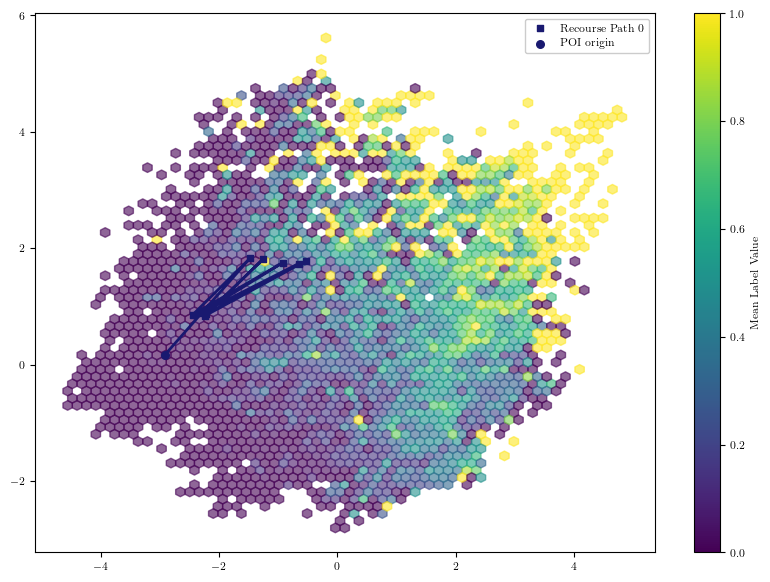

In [99]:
preprocessor.perturb_ratio = None
preprocessor.rescale_ratio = 0.8

check_certainty = recourse_iterator.wrap_model(model)
certainty_cutoff = 0.75


dice = dice_method.DiCE(
    1,
    preprocessor,
    dataset,
    preprocessor.continuous_features,
    model,
    model_backend='sklearn',
    label_column='income',
    dice_cfe_kwargs={'stopping_threshold': certainty_cutoff})

poi = utils.random_poi(dataset, column='income', label = '<=50K')

iterator = recourse_iterator.RecourseIterator(
    dice,
    preprocessor,
    certainty_cutoff=certainty_cutoff,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 10)

transformed_paths = [preprocessor.transform(path) for path in paths]

Display2DPaths(
    preprocessor.transform(dataset.drop('income', axis=1)).to_numpy(),
    dataset['income'].to_numpy(),
    positive_label = '>50K'
).do_pca().set_paths(transformed_paths).heatmap()

preprocessor.perturb_ratio = None
preprocessor.rescale_ratio = None